# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Clean up and install compatible versions
#!pip uninstall -y tensorflow protobuf google-api-core google-cloud-automl google-generativeai google-cloud-translate chromadb
!pip uninstall -qqy jupyterlab kfp > /dev/null 2>&1

# Install chromadb with compatible versions
!pip install -qU --no-warn-conflicts "google-genai==1.7.0" chromadb==0.6.3 
# #!pip install -U google-api-core==2.16.0

!pip install -q --no-warn-conflicts google-cloud-speech

# Install base packages with minimal dependencies
!pip install -q --no-warn-conflicts pandas matplotlib seaborn 
!pip install -q --no-warn-conflicts kagglehub[pandas-datasets]
!pip install -q --no-warn-conflicts soundfile pydub ipywidgets openai

# Install compatible versions
#!pip install -q google-generativeai  # Latest version instead of 1.7.0




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 71.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55

## Import Libraries

Now let's import the libraries we'll need for this step.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
from pathlib import Path
import datetime
import random
import warnings
from openai import OpenAI
import io
import tempfile

import ipywidgets as widgets
from IPython.display import Audio, clear_output, display, HTML, clear_output, Markdown
from typing import Dict, List, Optional, Tuple, Any


import sqlite3
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings

# Set warnings filter
warnings.filterwarnings('ignore')

# Audio processing libraries with error handling
try:
    import soundfile as sf
    import sounddevice as sd
    from IPython.display import Audio, display
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    print(f"Warning: Audio libraries could not be imported: {e}")

# Google Cloud Speech-to-Text (with error handling)
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry

# Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
genai.__version__

Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!


'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [4]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
    interactions_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
    vectorized_recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv')
    vectorized_users_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv')
    nutrition_df = pd.read_csv('/kaggle/input/nutritional-breakdown-of-foods/cleaned_nutrition_dataset.csv')

    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")
    print(f"Successfully loaded vectorized recipe data with {len(vectorized_recipes_df)} records")
    print(f"Successfully loaded vectorized user data with {len(vectorized_users_df)} records")
    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully loaded vectorized recipe data with 178265 records
Successfully loaded vectorized user data with 25076 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [5]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")
analyze_dataframe(vectorized_recipes_df, "Vectorized Recipes")
analyze_dataframe(vectorized_users_df, "Vectorized Users")





=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)

Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_id: int64
recipe_id: int64
date: object
rating: int6

In [6]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                             name      id  minutes  contributor_id  \
21561       belgian beer marinade  423694        5         1058097   
157010         pecan lace cookies  172667       30          212417   
39224   cheese and fruit smoothie  252157        5          430471   

         submitted  \
21561   2010-05-06   
157010  2006-06-15   
39224   2007-09-11   

                                                                                                       tags  \
21561   [15-minutes-or-less, time-to-make, course, cuisine, preparation, condiments-etc, easy, european,...   
157010  [30-minutes-or-less, time-to-make, course, main-ingredient, preparation, drop-cookies, desserts,...   
39224   [15-minutes-or-less, time-to-make, course, preparation, for-1-or-2, low-protein, healthy, bevera...   

                                         nutrition  n_steps  \
21561   [423.8, 41.0, 48.0, 57.0, 6.0, 10.0, 10.0]        3   
157010    [138.8, 12.0, 54.0, 1.0, 2.0, 10.0,

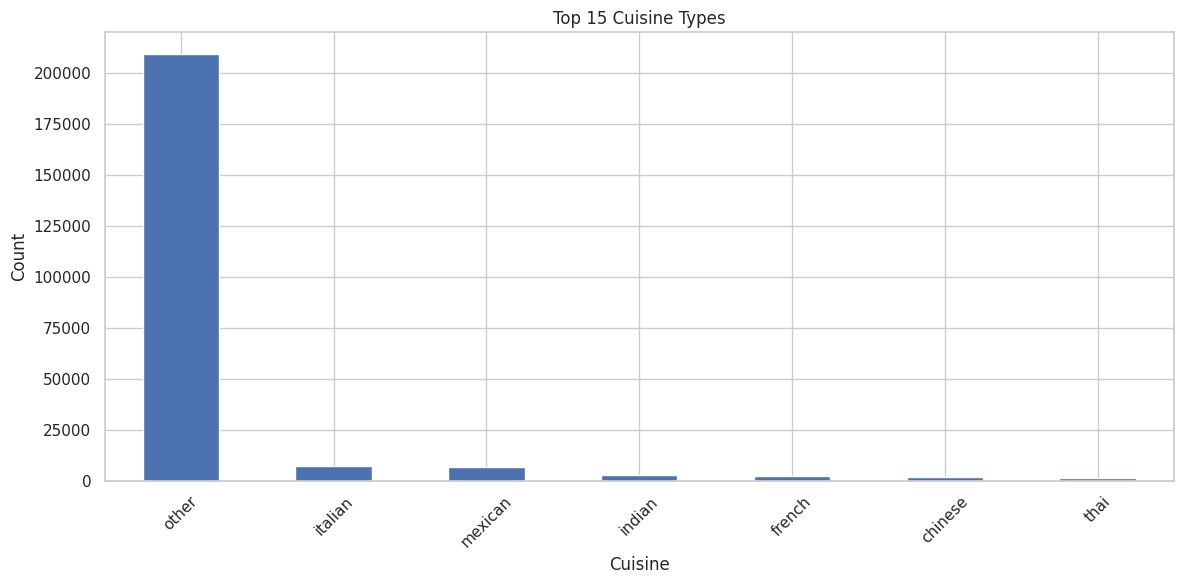

In [7]:
# Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

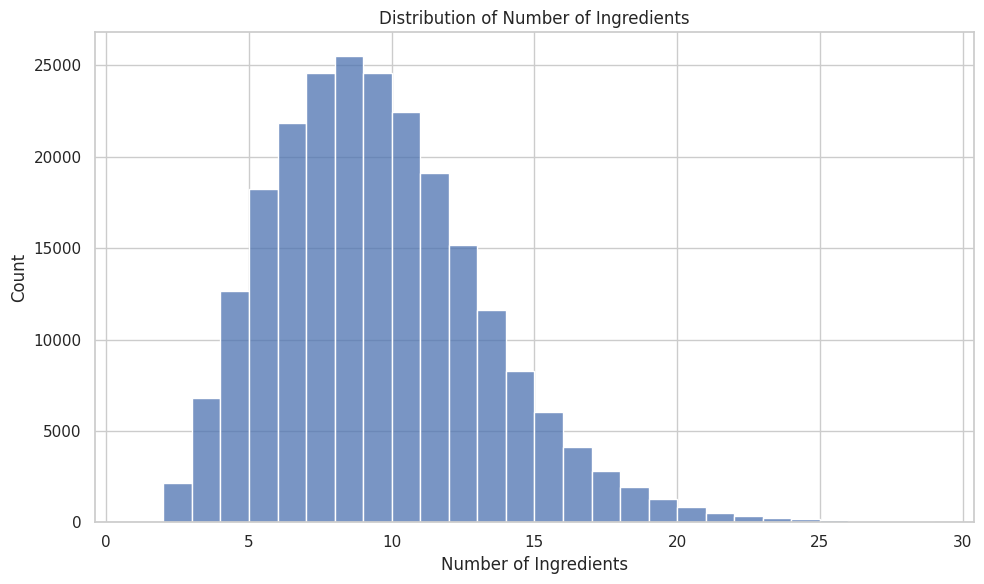

In [9]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [10]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [11]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")
vectorized_recipes_df = check_remove_duplicates(vectorized_recipes_df, "Vectorized Recipes")
vectorized_users_df = check_remove_duplicates(vectorized_users_df, "Vectorized Users")


=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Vectorized Recipes:
------------------------------
Using ID columns for duplicate check: ['id', 'ingredient_ids']
Number of duplicates in Vectorized Recipes: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for

In [12]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


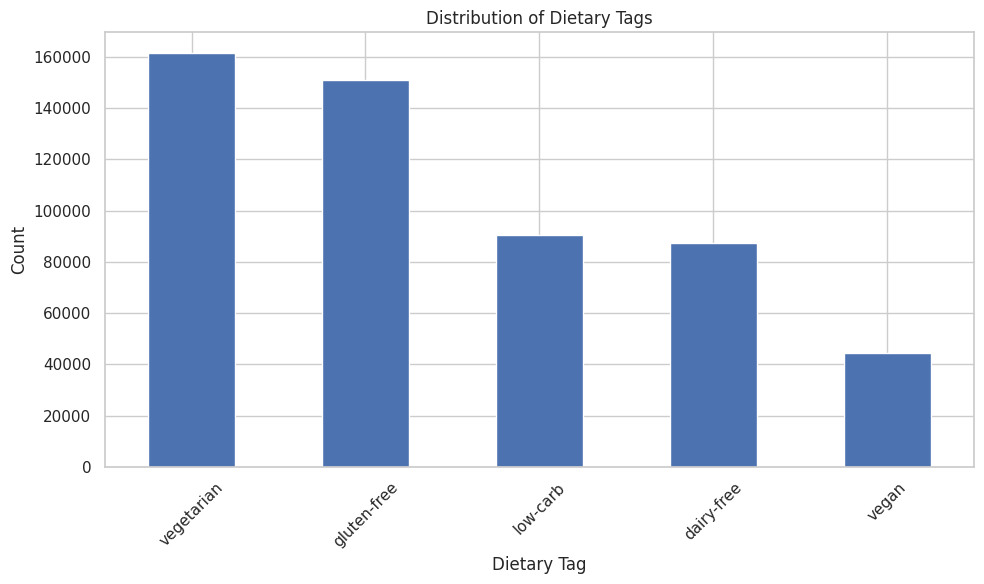


Sample recipes with dietary tags:

Recipe: st  louis  amighetti sandwich  copycat
Ingredients: mayonnaise, sour cream, dijon mustard, green onions, horseradish, fresh dill, french bread, cooked ham, roast beef, genoa salami, dill pickle slices, tomatoes, swiss cheese, pickled peppers
Dietary Tags: None

Recipe: mom s   molded   jello  salad
Ingredients: red jell-o, boiling water, whole berry cranberry sauce, crushed pineapple, cold water, mayonnaise, sour cream
Dietary Tags: vegetarian, gluten-free, low-carb

Recipe: louisiana best steak marinade
Ingredients: fresh lemon juice, dry mustard, salt, fresh coarse ground black pepper, worcestershire sauce, accent seasoning, garlic clove, soy sauce, salad oil, steak
Dietary Tags: vegetarian, vegan, gluten-free, low-carb, dairy-free

Recipe: hamburger spinach casserole
Ingredients: lean ground beef, onion, frozen chopped spinach, cream of mushroom soup, soy sauce, black pepper, cajun seasoning, cheddar cheese, dry breadcrumbs
Dietary Tags: N

In [13]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

In [14]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nrecipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")
print("Vectorized Datasets information:")

print(f"Number of vectorized recipes: {len(vectorized_recipes_df)}")
print("\nvectorized_recipes_df columns:")
print(vectorized_recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of vectorized users: {len(vectorized_users_df)}")
print("\nvectorized_users_df columns:")
print(vectorized_users_df.columns.tolist())
print(15 * "-")

Raw Datasets information:
Number of recipes: 230186

recipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'normalized_ingredients', 'dietary_tags']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------
Vectorized Datasets information:
Number of vectorized recipes: 178265

vectorized_recipes_df columns:
['id', 'i', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'techniques', 'calorie_level', 'ingredient_ids']
---------------
Number of vectorized users: 25076

vectorized_users_df columns:
['u', 'techniques', 'items', 'n_items', 'ratings', 'n_ra

In [15]:
# For any DataFrame, e.g., vectorized_users_df


# For a more readable format with column names and types:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Wider display
pd.set_option('display.max_colwidth', 100)  # Show more content in each cell

print("\n=== VECTORIZED USERS DATAFRAME ===\n")

# Display column names and types
print("Column names and data types:")
for col, dtype in vectorized_users_df.dtypes.items():
    print(f"{col}: {dtype}")

# Display a single row with full information
print("\nExample row (complete):")
example_row = vectorized_users_df.iloc[0:1]
print(example_row.to_string())

# Optional: Display example row as dictionary for even more clarity
print("\nExample row as dictionary:")
row_dict = example_row.to_dict('records')[0]
for key, value in row_dict.items():
    print(f"{key}: {value}")

print("\n" + 50 * "=")

print("\n=== VECTORIZED RECIPES DATAFRAME ===\n")

# Display column names and types
print("Column names and data types:")
for col, dtype in vectorized_recipes_df.dtypes.items():
    print(f"{col}: {dtype}")

# Display a single row with full information
print("\nExample row (complete):")
example_row = vectorized_recipes_df.iloc[0:1]
print(example_row.to_string())

# Optional: Display example row as dictionary for even more clarity
print("\nExample row as dictionary:")
row_dict = example_row.to_dict('records')[0]
for key, value in row_dict.items():
    print(f"{key}: {value}")

# Reset pandas display options to default (optional)
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')



=== VECTORIZED USERS DATAFRAME ===

Column names and data types:
u: int64
techniques: object
items: object
n_items: int64
ratings: object
n_ratings: int64

Example row (complete):
   u                                                                                                                                                                      techniques                                                                                                                                                                                                                          items  n_items                                                                                                                                                      ratings  n_ratings
0  0  [8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, 0, 5, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 8, 0, 0, 8, 2, 2, 0, 0, 0, 3, 3, 1, 0, 5, 0, 0, 2, 1, 1, 0, 3, 1, 7, 2, 2]  [1118, 27680, 32541, 137353, 16428, 28815, 65803, 148743

## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [16]:

# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"

#####################
# SQL Database Setup
#####################
def safe_convert(x):
    """
    Safely converts a value to a string:
      - If x is a list or numpy array, join its elements into a space-separated string.
      - If x is not a list/array and is not null, convert to string.
      - Otherwise, return an empty string.
    """
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""


def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess DataFrame columns to be SQLite-compatible.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(safe_convert)
    return df

def setup_sql_database(
    recipes_df: pd.DataFrame, 
    interactions_df: pd.DataFrame, 
    nutrition_df: Optional[pd.DataFrame] = None,
    db_path: str = DB_PATH
) -> sqlite3.Connection:
    """
    Set up SQLite database with raw dataframes.
    """
    recipes_df = preprocess_dataframe(recipes_df)
    interactions_df = preprocess_dataframe(interactions_df)
    if nutrition_df is not None:
        nutrition_df = preprocess_dataframe(nutrition_df)

    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Creating SQLite database at {db_path}")
    conn = sqlite3.connect(db_path)
    
    print(f"Storing {len(recipes_df)} recipes in the database")
    recipes_df.to_sql('recipes', conn, if_exists='replace', index=False)
    print(f"Storing {len(interactions_df)} interactions in the database")
    interactions_df.to_sql('interactions', conn, if_exists='replace', index=False)
    
    if nutrition_df is not None:
        print(f"Storing {len(nutrition_df)} nutrition entries in the database")
        nutrition_df.to_sql('nutrition', conn, if_exists='replace', index=False)
    
    print("SQL database setup complete")
    return conn

#############################
# Vector Database Setup (ChromaDB)
#############################
def setup_vector_database(
    vectorized_recipes_df: pd.DataFrame,
    vectorized_interactions_df: Optional[pd.DataFrame] = None,
    vector_db_path: str = VECTOR_DB_PATH
) -> Tuple[Any, Any, Optional[Any]]:
    """
    Set up ChromaDB using the precomputed dataframes for recipes and interactions.
    
    Arguments:
        vectorized_recipes_df: DataFrame with your recipe data.
        vectorized_interactions_df: DataFrame with your interaction data.
        vector_db_path: Directory where ChromaDB will store its data.
        
    Returns:
        A tuple containing the ChromaDB client, the recipe collection, and 
        the interactions collection (if interactions_df is provided).
    """
    os.makedirs(vector_db_path, exist_ok=True)
    print(f"Creating ChromaDB at {vector_db_path}")
    client = chromadb.PersistentClient(path=vector_db_path)
    
    #########################
    # Load recipes into ChromaDB
    #########################
    print(f"Setting up recipe collection with {len(vectorized_recipes_df)} recipes")
    recipe_collection = client.get_or_create_collection(name="recipes")
    
    recipe_documents = []
    recipe_metadatas = []
    recipe_ids = []
    
    # Define which recipe columns to include as metadata
    metadata_fields = ['name', 'minutes', 'contributor_id', 'submitted',
                       'tags', 'nutrition', 'n_steps', 'cuisine_type',
                       'n_ingredients', 'dietary_tags']
    
    for i, row in vectorized_recipes_df.iterrows():
        # Determine a unique recipe ID. Use 'id' column if available.
        recipe_id = row.get('id')
        if recipe_id is None or (isinstance(recipe_id, float) and pd.isna(recipe_id)) or recipe_id == "":
            recipe_id = str(i)
        else:
            recipe_id = str(recipe_id)
        recipe_ids.append(recipe_id)
        
        # Build a document string by concatenating key text fields.
        # You may adjust the fields below to better capture recipe information.
        doc_text = " ".join([
            safe_convert(row.get('name', '')),
            safe_convert(row.get('ingredients', '')),
            safe_convert(row.get('steps', '')),
            safe_convert(row.get('description', ''))
        ])
        recipe_documents.append(doc_text)
        
        # Build richer metadata from the chosen fields.
        metadata = {key: safe_convert(row.get(key, "")) for key in metadata_fields}
        metadata['recipe_id'] = recipe_id
        recipe_metadatas.append(metadata)
    
    batch_size = 1000
    for j in range(0, len(recipe_documents), batch_size):
        end_idx = min(j + batch_size, len(recipe_documents))
        recipe_collection.add(
            documents=recipe_documents[j:end_idx],
            metadatas=recipe_metadatas[j:end_idx],
            ids=recipe_ids[j:end_idx]
        )
    
    #########################
    # Load interactions into ChromaDB (if provided)
    #########################
    interactions_collection = None
    if vectorized_interactions_df is not None and not vectorized_interactions_df.empty:
        print(f"Setting up interactions collection with {len(vectorized_interactions_df)} interactions")
        interactions_collection = client.get_or_create_collection(name="interactions")
        
        interaction_documents = []
        interaction_metadatas = []
        interaction_ids = []
        
        for i, row in vectorized_interactions_df.iterrows():
            # Create a unique interaction ID from user_id, recipe_id, and index.
            user_id = safe_convert(row.get('user_id', ''))
            recipe_id = safe_convert(row.get('recipe_id', ''))
            interaction_id = f"{user_id}_{recipe_id}_{i}"
            interaction_ids.append(interaction_id)
            
            # Use the review text as the primary document.
            review_text = safe_convert(row.get('review', ''))
            if not review_text:
                review_text = "No review provided."
            interaction_documents.append(review_text)
            
            # Build metadata for this interaction.
            int_metadata = {
                'interaction_id': interaction_id,
                'user_id': user_id,
                'recipe_id': recipe_id,
                'date': safe_convert(row.get('date', '')),
                'rating': safe_convert(row.get('rating', ''))
            }
            interaction_metadatas.append(int_metadata)
        
        for j in range(0, len(interaction_documents), batch_size):
            end_idx = min(j + batch_size, len(interaction_documents))
            interactions_collection.add(
                documents=interaction_documents[j:end_idx],
                metadatas=interaction_metadatas[j:end_idx],
                ids=interaction_ids[j:end_idx]
            )
    
    print("Vector database setup complete")
    return client, recipe_collection, interactions_collection



In [17]:
# Set up the SQL database
sqlite_conn = setup_sql_database(
    recipes_df=recipes_df,
    interactions_df=interactions_df,
    nutrition_df=nutrition_df,  # Modify if you have nutrition data.
    db_path=DB_PATH
)


Creating SQLite database at final/kitchen_db.sqlite
Storing 230186 recipes in the database
Storing 1132367 interactions in the database
Storing 3454 nutrition entries in the database
SQL database setup complete


In [18]:
import chromadb
print(chromadb.__version__)

0.6.3


In [ ]:
# !rm -rf /kaggle/working/final/vector_db/

In [19]:
# Path to your vector database
VECTOR_DB_PATH = "/kaggle/input/food-com-vectorized-with-chromadb/vector_db"

def explore_chromadb_collections(db_path: str = VECTOR_DB_PATH):
    """
    List all collections in the ChromaDB database and their sizes.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    collection_names = client.list_collections()
    
    print(f"=== ChromaDB at {db_path} ===\n")
    print(f"Found {len(collection_names)} collections:")
    
    for name in collection_names:
        # In v0.6.0, we need to get the collection by name
        collection = client.get_collection(name=str(name))
        
        # Get the count for this collection
        try:
            # v0.6.0 requires where parameter
            count = collection.count(where={})
            print(f"  - {name}: {count} records")
        except Exception as e:
            print(f"  - {name}: Error getting count - {str(e)}")
    
    return collection_names


def view_collection_sample(collection_name: str, sample_size: int = 5, db_path: str = VECTOR_DB_PATH):
    """
    View a random sample of records from the specified collection.
    
    Args:
        collection_name: Name of the collection to sample
        sample_size: Number of random samples to retrieve
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get total count
    try:
        total_count = collection.count(where={})
        if total_count == 0:
            print(f"Collection '{collection_name}' is empty.")
            return None
        
        print(f"\n=== Sample from '{collection_name}' collection ({total_count} total records) ===\n")
        
        # Get all IDs first (needed since v0.6.0 API changes)
        all_results = collection.get(where={}, include=['embeddings'])
        all_ids = all_results['ids']
        
        # Determine sample size
        actual_sample_size = min(sample_size, total_count)
        
        # Get random sample of IDs
        if total_count > actual_sample_size:
            sample_ids = random.sample(all_ids, actual_sample_size)
        else:
            sample_ids = all_ids
        
        # Retrieve the sampled records
        results = collection.get(
            ids=sample_ids,
            include=['metadatas', 'documents']
        )
        
        # Display each record
        for i, (doc_id, doc, metadata) in enumerate(zip(
            results['ids'],
            results['documents'],
            results['metadatas']
        )):
            print(f"\n--- Record {i+1}/{actual_sample_size} ---")
            print(f"ID: {doc_id}")
            
            # Display metadata in a readable format
            print("\nMetadata:")
            for key, value in metadata.items():
                # Truncate long values
                if isinstance(value, str) and len(value) > 100:
                    value = value[:100] + "..."
                print(f"  {key}: {value}")
            
            # Display a preview of the document text
            if doc:
                doc_preview = doc[:150] + "..." if len(doc) > 150 else doc
                print(f"\nDocument preview: {doc_preview}")
            else:
                print("\nDocument: None")
        
        return results
    
    except Exception as e:
        print(f"Error accessing collection: {str(e)}")
        return None


def export_collection_to_csv(collection_name: str, output_path: Optional[str] = None, 
                            db_path: str = VECTOR_DB_PATH):
    """
    Export a collection to CSV for easier viewing and analysis.
    
    Args:
        collection_name: Name of the collection to export
        output_path: Path to save the CSV file (default: "{collection_name}_export.csv")
        db_path: Path to the ChromaDB database
    """
    if output_path is None:
        output_path = f"{collection_name}_export.csv"
    
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get all records
    try:
        results = collection.get(
            where={},
            include=['metadatas', 'documents']
        )
        
        # Check if we have data
        if not results['ids']:
            print(f"Collection '{collection_name}' is empty.")
            return None
        
        # Create a list of dictionaries for the DataFrame
        records = []
        for i, (doc_id, doc, metadata) in enumerate(zip(
            results['ids'],
            results['documents'],
            results['metadatas']
        )):
            record = {'id': doc_id, 'document': doc}
            
            # Add metadata fields
            for key, value in metadata.items():
                record[f'metadata_{key}'] = value
            
            records.append(record)
        
        # Convert to DataFrame and export
        df = pd.DataFrame(records)
        df.to_csv(output_path, index=False)
        
        print(f"\nExported {len(records)} records from '{collection_name}' to {output_path}")
        print(f"DataFrame columns: {', '.join(df.columns)}")
        
        return df
    
    except Exception as e:
        print(f"Error exporting collection: {str(e)}")
        return None


def view_schema_info(collection_name: str, db_path: str = VECTOR_DB_PATH):
    """
    View schema information for a collection (metadata fields and their data types).
    
    Args:
        collection_name: Name of the collection to analyze
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get a sample of records to analyze schema
    try:
        results = collection.get(
            limit=100,
            include=['metadatas']
        )
        
        if not results['metadatas']:
            print(f"Collection '{collection_name}' is empty or has no metadata.")
            return None
        
        # Analyze metadata fields
        print(f"\n=== Schema for '{collection_name}' collection ===\n")
        print("Metadata fields:")
        
        # Collect all possible keys and their types
        all_keys = set()
        key_types = {}
        key_examples = {}
        
        for metadata in results['metadatas']:
            for key, value in metadata.items():
                all_keys.add(key)
                
                # Track the data type
                value_type = type(value).__name__
                if key not in key_types:
                    key_types[key] = set()
                key_types[key].add(value_type)
                
                # Store an example value
                if key not in key_examples and value:
                    example = str(value)
                    if len(example) > 50:
                        example = example[:50] + "..."
                    key_examples[key] = example
        
        # Display the schema information
        for key in sorted(all_keys):
            types_str = ", ".join(key_types[key])
            example = key_examples.get(key, "N/A")
            print(f"  - {key}: {types_str}")
            print(f"    Example: {example}")
        
        return key_types
    
    except Exception as e:
        print(f"Error getting schema info: {str(e)}")
        return None


def simple_collection_info(db_path: str = VECTOR_DB_PATH):
    """
    A simple function to display basic information about all collections.
    More robust against API changes than the other functions.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection_names = client.list_collections()
        print(f"Found {len(collection_names)} collections in {db_path}:")
        
        for name in collection_names:
            print(f"\nCollection: {name}")
            
            try:
                collection = client.get_collection(name=str(name))
                
                # Try to get count
                try:
                    count = collection.count(where={})
                    print(f"  Records: {count}")
                except:
                    print("  Count: Could not retrieve")
                
                # Try to get the first few items
                try:
                    first_items = collection.get(limit=3, include=["metadatas"])
                    print(f"  Sample IDs: {first_items['ids']}")
                    
                    # Show first item metadata as example
                    if first_items['metadatas'] and len(first_items['metadatas']) > 0:
                        print("  Sample metadata keys:", list(first_items['metadatas'][0].keys()))
                except:
                    print("  Sample: Could not retrieve")
                    
            except Exception as e:
                print(f"  Error accessing collection: {str(e)}")
        
    except Exception as e:
        print(f"Error listing collections: {str(e)}")

In [26]:

client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
print(client.list_collections())


['interactions', 'recipes']


In [31]:
view_schema_info(collection_name ="recipes", db_path = VECTOR_DB_PATH)


=== Schema for 'recipes' collection ===

Metadata fields:
  - contributor_id: str
    Example: 47892
  - cuisine_type: str
    Example: mexican
  - dietary_tags: str
    Example: vegetarian gluten-free low-carb
  - minutes: str
    Example: 55
  - n_ingredients: str
    Example: 7
  - n_steps: str
    Example: 11
  - name: str
    Example: arriba   baked winter squash mexican style
  - nutrition: str
    Example: [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
  - recipe_id: str
    Example: 137739
  - submitted: str
    Example: 2005-09-16
  - tags: str
    Example: 60-minutes-or-less time-to-make course main-ingred...


{'contributor_id': {'str'},
 'cuisine_type': {'str'},
 'dietary_tags': {'str'},
 'minutes': {'str'},
 'n_ingredients': {'str'},
 'n_steps': {'str'},
 'name': {'str'},
 'nutrition': {'str'},
 'recipe_id': {'str'},
 'submitted': {'str'},
 'tags': {'str'}}

In [32]:
simple_collection_info(db_path = VECTOR_DB_PATH)

Found 2 collections in /kaggle/input/food-com-vectorized-with-chromadb/vector_db:

Collection: interactions
  Count: Could not retrieve
  Sample IDs: ['38094_40893_0', '1293707_40893_1', '8937_44394_2']
  Sample metadata keys: ['date', 'interaction_id', 'rating', 'recipe_id', 'user_id']

Collection: recipes
  Count: Could not retrieve
  Sample IDs: ['137739', '31490', '112140']
  Sample metadata keys: ['contributor_id', 'cuisine_type', 'dietary_tags', 'minutes', 'n_ingredients', 'n_steps', 'name', 'nutrition', 'recipe_id', 'submitted', 'tags']


In [34]:

def recipe_similarity_search(query_text, n_results=5):
    """
    The similarity search functionality on the recipe collection.
    
    Args:
        query_text (str): The text to search for similar recipes
        n_results (int): Number of results to return
        
    Returns:
        List of similar recipes with their metadata
    """
    # Connect to the existing ChromaDB
    client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
    
    # Get the recipes collection
    recipe_collection = client.get_collection(name="recipes")
    
    # Perform the similarity search
    results = recipe_collection.query(
        query_texts=[query_text],
        n_results=n_results,
        include=["documents", "metadatas", "distances"]
    )
    
    print(f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'")
    print("\nTop Results:")
    print("-" * 80)
    
    # Format and display the results
    for i, (doc_id, doc, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['documents'][0],
        results['metadatas'][0],
        results['distances'][0]
    )):
        print(f"\n{i+1}. Recipe: {metadata.get('name', 'Unnamed')}")
        print(f"   Similarity score: {1 - distance:.4f}")  # Convert distance to similarity score
        print(f"   Recipe ID: {doc_id}")
        
        # Display additional metadata if available
        if 'cuisine_type' in metadata and metadata['cuisine_type']:
            print(f"   Cuisine: {metadata['cuisine_type']}")
        if 'minutes' in metadata and metadata['minutes']:
            print(f"   Cooking time: {metadata['minutes']} minutes")
        if 'n_ingredients' in metadata and metadata['n_ingredients']:
            print(f"   Number of ingredients: {metadata['n_ingredients']}")
        
        # Print a short preview of the document text
        doc_preview = doc[:150] + "..." if len(doc) > 150 else doc
        print(f"   Document preview: {doc_preview}")
    
    return results

def interaction_similarity_search(query_text, n_results=5):
    """
    The similarity search functionality on the interactions collection.
    
    Args:
        query_text (str): The text to search for similar interactions/reviews
        n_results (int): Number of results to return
        
    Returns:
        List of similar interactions with their metadata
    """
    # Connect to the existing ChromaDB
    client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
    
    try:
        # Get the interactions collection
        interactions_collection = client.get_collection(name="interactions")
        
        # Perform the similarity search
        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )
        
        print(f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'")
        print("\nTop Results:")
        print("-" * 80)
        
        # Format and display the results
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            print(f"\n{i+1}. Review ID: {doc_id}")
            print(f"   Similarity score: {1 - distance:.4f}")  # Convert distance to similarity score
            print(f"   User ID: {metadata.get('user_id', 'Unknown')}")
            print(f"   Recipe ID: {metadata.get('recipe_id', 'Unknown')}")
            
            # Display additional metadata
            if 'rating' in metadata and metadata['rating']:
                print(f"   Rating: {metadata['rating']}")
            if 'date' in metadata and metadata['date']:
                print(f"   Date: {metadata['date']}")
            
            # Print the review text
            print(f"   Review: {doc}")
        
        return results
    except ValueError:
        print("Interactions collection not found. Make sure you have interaction data loaded.")
        return None

In [35]:
query_text = "mexcian pizza"
recipe_similarity_search(query_text, n_results = 1)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 105MiB/s] 


Found 1 similar recipes for query: 'mexcian pizza'

Top Results:
--------------------------------------------------------------------------------

1. Recipe: tex mex pizza
   Similarity score: 0.0683
   Recipe ID: 134510
   Cuisine: other
   Cooking time: 48 minutes
   Number of ingredients: 13
   Document preview: tex mex pizza cornmeal frozen bread dough ground sirloin onion yellow sweet pepper garlic clove fat-free refried beans salsa green chilies chili powde...


{'ids': [['134510']],
 'embeddings': None,
 'documents': [["tex mex pizza cornmeal frozen bread dough ground sirloin onion yellow sweet pepper garlic clove fat-free refried beans salsa green chilies chili powder reduced-fat mexican cheese blend tomatoes lettuce coat two 12-inch pizza pans with nonstick cooking spray and sprinkle with cornmeal divide the bread dough in half and roll each portion into a 12-inch circle transfer to prepared pans and build up edges slightly prick dough thoroughly with a fork bake at 425 degrees for 12 minutes or until slightly browned meanwhile , in a skillet , cook the beef , onion , yellow pepper , and garlic over medium heat until the meat is no longer pink drain stir in refried beans , salsa , chilies , and chili powder heat through spread over the crusts sprinkle with cheese bake 6-7 minutes longer or until cheese is melted top with tomatoes and lettuce serve immediately this is quite tasty and very different from the normal pizza. it's also healthy --

In [36]:
query_text = "pizza and easy to make"
interaction_similarity_search(query_text, n_results = 1)

Found 1 similar reviews for query: 'pizza and easy to make'

Top Results:
--------------------------------------------------------------------------------

1. Review ID: 145352_30021_568540
   Similarity score: 0.6509
   User ID: 145352
   Recipe ID: 30021
   Rating: 4
   Date: 2006-12-21
   Review: Pretty good pizza...and easy too!


{'ids': [['145352_30021_568540']],
 'embeddings': None,
 'documents': [['Pretty good pizza...and easy too!']],
 'uris': None,
 'data': None,
 'metadatas': [[{'date': '2006-12-21',
    'interaction_id': '145352_30021_568540',
    'rating': '4',
    'recipe_id': '30021',
    'user_id': '145352'}]],
 'distances': [[0.34911778569221497]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [46]:
# ============================================================
# PART 2: Database Query Functions
# ============================================================
#DB_PATH = "/kaggle/working/final/kitchen_db.sqlite"
def list_tables():
    """List all tables in the SQLite database."""
    db_path = "/kaggle/working/final/kitchen_db.sqlite"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    return [table[0] for table in tables]

def describe_table(table_name:str):
    """Describe the schema of a specified table."""
    db_path = "/kaggle/working/final/kitchen_db.sqlite"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    return [(col[1], col[2]) for col in schema]

def execute_query(sql:str):
    """Execute an SQL query and return the results."""
    db_path = "/kaggle/working/final/kitchen_db.sqlite"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

def get_recipe_by_id(recipe_id:str):
    """Get a recipe by its ID with all details."""
    db_path = "/kaggle/working/final/kitchen_db.sqlite"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
    recipe_data = cursor.fetchone()
    
    if not recipe_data:
        return None
    
    columns = [col[0] for col in cursor.description]
    recipe = dict(zip(columns, recipe_data))
    
    # Parse JSON fields
    for field in ["steps", "ingredients", "nutrition"]:
        if recipe[field]:
            recipe[field] = json.loads(recipe[field])
    
    return recipe


In [47]:

# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query, get_recipe_by_id]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

In [53]:
resp = chat.send_message("find a mexican pizza recipe in recipes table!")
print(f"\n{resp.text}")


OK. I found a recipe called "chi chi s mexican pizza" with the id 263498. It takes 60 minutes or less to make. The ingredients are ground beef, water, ground cumin, oregano, salt, flour tortillas, vegetable oil, tomatoes, black olives, green onions, green chilies, and cheddar cheese.



In [56]:
resp = chat.send_message("load the full data of id 263498 in recipes table! but in a markdown format")
display(Markdown(resp.text))

```markdown
**Recipe Name:** chi chi s mexican pizza
**Recipe ID:** 263498
**Minutes to Prepare:** 40
**Contributor ID:** 90086
**Date Submitted:** 2007-11-05
**Tags:** 60-minutes-or-less, time-to-make, course, cuisine, preparation, occasion, north-american, main-dish, mexican, finger-food, pizza, copycat, one-dish-meal, comfort-food, novelty, taste-mood, presentation, served-hot
**Nutrition Information:**
* Calories: 875.8
* Total Fat: 78.0
* Sugar: 26.0
* Sodium: 74.0
* Protein: 71.0
* Saturated Fat: 96.0
* Carbohydrates: 23.0
**Number of Steps:** 8
**Cooking Instructions:**
1. preheat oven to 400
2. fry the ground beef with the water , the cumin , oregano and salt , stirring until the water has evaporated
3. drain excess grease cool
4. rub each tortilla on each side with a bit of vegetable oil
5. place tortillas on a baking sheet and bake for 4 minutes
6. remove from oven , and top with the seasoned beef , veggies , then the cheese
7. bake for 10 minutes , or until the cheese is melted

**Description:** this is my clone version of chi-chi's original mexican pizza, before they changed the recipe and went out of business, lol.
**Ingredients:** ground beef water ground cumin oregano salt flour tortillas vegetable oil tomatoes black olives green onions green chilies cheddar cheese
**Number of Ingredients:** 12
**Cuisine:** mexican
**Duplicate Ingredients:** ground beef water ground cumin oregano salt flour tortillas vegetable oil tomatoes black olives green onions green chilies cheddar cheese
```

In [ ]:

def search_recipes_by_text(recipe_collection, query_text, n_results=5):
    """Search recipes using vector similarity on text."""
    results = recipe_collection.query(
        query_texts=[query_text],
        n_results=n_results
    )
    
    # Extract the recipe IDs
    recipe_ids = []
    for metadata in results['metadatas'][0]:
        if 'recipe_id' in metadata:
            recipe_id = metadata['recipe_id']
            if recipe_id not in recipe_ids:
                recipe_ids.append(recipe_id)
    
    return recipe_ids

def search_recipes_by_ingredients(conn, recipe_collection, ingredients, n_results=5):
    """Search for recipes that contain the specified ingredients using embeddings."""
    # Convert ingredients list to a single string for embedding
    ingredients_text = ", ".join(ingredients)
    
    # Query the vector database
    results = recipe_collection.query(
        query_texts=[ingredients_text],
        n_results=n_results*2,  # Get more results than needed to filter
        where={"type": "ingredients"}
    )
    
    # Extract recipe IDs from the results
    recipe_ids = []
    for i, metadata in enumerate(results['metadatas'][0]):
        if 'recipe_id' in metadata:
            recipe_id = metadata['recipe_id']
            if recipe_id not in recipe_ids:
                recipe_ids.append(recipe_id)
    
    # Limit to the requested number of results
    recipe_ids = recipe_ids[:n_results]
    
    # Get full recipe details for each ID
    recipes = []
    for recipe_id in recipe_ids:
        recipe = get_recipe_by_id(conn, recipe_id)
        if recipe:
            recipes.append(recipe)
    
    return recipes

def get_similar_recipes(conn, recipe_collection, recipe_id, similarity_type="ingredients", n_results=3):
    """Find recipes similar to the given recipe based on the specified similarity type."""
    # Get the original recipe
    original_recipe = get_recipe_by_id(conn, recipe_id)
    if not original_recipe:
        return []
    
    # Query for similar recipes based on the similarity type
    query_id = f"{similarity_type}_{recipe_id}"
    
    try:
        results = recipe_collection.query(
            ids=[query_id],
            n_results=n_results + 1,  # +1 because it will include the original
            where={"type": similarity_type}
        )
    except Exception as e:
        print(f"Error querying vector database: {e}")
        
        # Fallback: query by text if ID query fails
        if similarity_type == "ingredients":
            query_text = ", ".join(original_recipe["ingredients"])
        elif similarity_type == "steps":
            query_text = " ".join(original_recipe["steps"])
        else:
            query_text = original_recipe["name"]
            
        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results + 1,
            where={"type": similarity_type}
        )
    
    # Extract recipe IDs excluding the original
    recipe_ids = []
    for metadata in results['metadatas'][0]:
        if 'recipe_id' in metadata:
            result_id = metadata['recipe_id']
            if result_id != recipe_id and result_id not in recipe_ids:
                recipe_ids.append(result_id)
    
    # Get complete recipe information
    similar_recipes = []
    for similar_id in recipe_ids[:n_results]:
        recipe = get_recipe_by_id(conn, similar_id)
        if recipe:
            similar_recipes.append(recipe)
    
    return similar_recipes